# Wine Quality

## I. Chuẩn bị dữ liệu

In [7]:
# Import các thư viện cần thiết
import os
import config as CONFIG
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#### 1. Lấy dữ liệu và xử lí thô

In [8]:
# Đọc dữ liệu rượu trắng
data_white = pd.read_csv(CONFIG.RAW_DATA_PATH_WHITE, delimiter=';')
data_white['wine_type'] = 'white'  # Thêm cột phân loại loại rượu

# Đọc dữ liệu rượu đỏ
data_red = pd.read_csv(CONFIG.RAW_DATA_PATH_RED, delimiter=';')
data_red['wine_type'] = 'red'  # Thêm cột phân loại loại rượu

# Ghép hai dữ liệu
data = pd.concat([data_white, data_red], axis=0, ignore_index=True)

# Mã hóa 'wine_type' thành giá trị số
encoder = LabelEncoder()
data['wine_type'] = encoder.fit_transform(data['wine_type'])

#### 2. Tiền xử lý dữ liệu

In [9]:
# Thêm cột "Quality_Category" để nhóm chất lượng
# 0-4: Chất lượng thấp, 5-6: Tiêu chuẩn, 7-10: Chất lượng cao
data['Quality_Category'] = pd.cut(
    data['quality'],
    bins=[-1, 4, 6, 10],
    labels=['Low', 'Standard', 'High']
)

# Loại bỏ cột "quality" (không cần thiết)
data = data.drop(columns=['quality'])

X = data.drop(columns=['Quality_Category'])

y = data['Quality_Category']

In [10]:
# Chuyển đổi nhãn thành số
y = encoder.fit_transform(y)

In [11]:
# Kiểm tra thông tin dữ liệu
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         6497 non-null   float64 
 1   volatile acidity      6497 non-null   float64 
 2   citric acid           6497 non-null   float64 
 3   residual sugar        6497 non-null   float64 
 4   chlorides             6497 non-null   float64 
 5   free sulfur dioxide   6497 non-null   float64 
 6   total sulfur dioxide  6497 non-null   float64 
 7   density               6497 non-null   float64 
 8   pH                    6497 non-null   float64 
 9   sulphates             6497 non-null   float64 
 10  alcohol               6497 non-null   float64 
 11  wine_type             6497 non-null   int64   
 12  Quality_Category      6497 non-null   category
dtypes: category(1), float64(11), int64(1)
memory usage: 615.7 KB
None


In [12]:
# Kiểm tra sơ bộ
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  wine_type Quality_Category  
0      8.8          1         Standard  
1   

In [13]:
# Kiểm tra giá trị duy nhất trong nhãn:
print(data['Quality_Category'].value_counts())

Quality_Category
Standard    4974
High        1277
Low          246
Name: count, dtype: int64


In [14]:
# Kiểm tra thống kê dữ liệu:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

#### 3. Xáo trộn dữ liệu

In [15]:
rand_value = CONFIG.RANDOM_STATE
data = shuffle(data, random_state=rand_value)

#### 4. Phân chia dữ liệu với các tỷ lệ khác nhau

In [16]:
splits = CONFIG.SPLIT_RATIOS
datasets = {}

In [17]:
for split_name, train_ratio in splits.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=rand_value
    )
    datasets[split_name] = {
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test,
    }

#### 5. Lưu dữ liệu vào CSV

In [18]:
# Tạo thư mục cha chứa các file path
dir_path = CONFIG.PROCESSED_CSV_DIR
os.makedirs(dir_path, exist_ok=True)

# Tạo các thư mục chính chứa file path
for split_name in splits.keys():
    os.makedirs(
        os.path.join(dir_path, split_name.replace('/', '_')), exist_ok=True
        )

In [19]:
try:
    # Lặp qua các phân chia trong datasets
    for split_name, dataset in datasets.items():
        # Đảm bảo rằng split_name là hợp lệ trong splits
        if split_name in splits:
            split_dir = os.path.join(dir_path, split_name.replace('/', '_'))
            
            # Lưu các dữ liệu vào các file CSV
            dataset['feature_train'].to_csv(os.path.join(split_dir, "train_features.csv"), index=False)
            pd.DataFrame(dataset['label_train']).to_csv(os.path.join(split_dir, "train_labels.csv"), index=False)
            dataset['feature_test'].to_csv(os.path.join(split_dir, "test_features.csv"), index=False)
            pd.DataFrame(dataset['label_test']).to_csv(os.path.join(split_dir, "test_labels.csv"), index=False)

    print("Lưu dữ liệu thành công!")

except Exception as e:
    print(f"Không thể lưu dữ liệu! Lỗi: {e}")

Lưu dữ liệu thành công!


#### 6. Hình dung phân phối nhãn

In [20]:
order = encoder.classes_
def plot_label_distribution(y, title):
    y_decoded = encoder.inverse_transform(y)
    sns.countplot(x=y_decoded,order=order)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

- Phân phối dữ liệu gốc

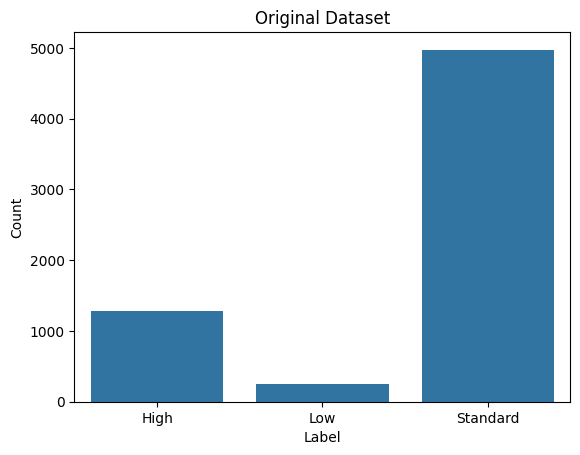

In [21]:
plot_label_distribution(y, 'Original Dataset')

- Phân phối các tập con

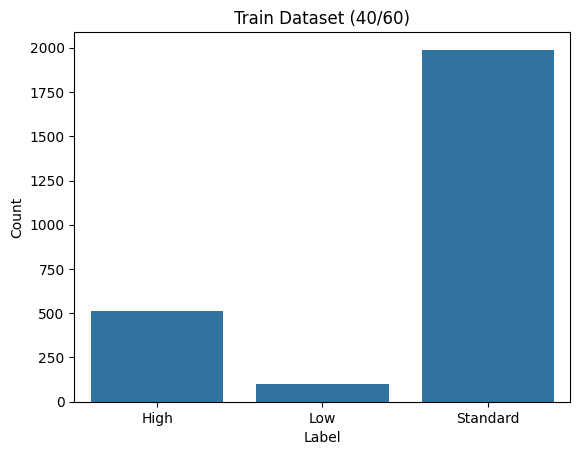

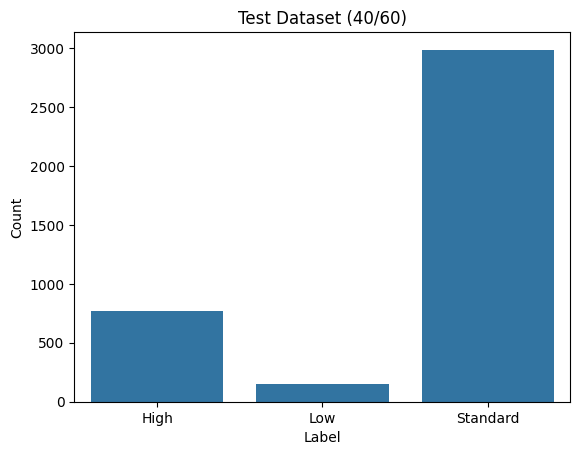

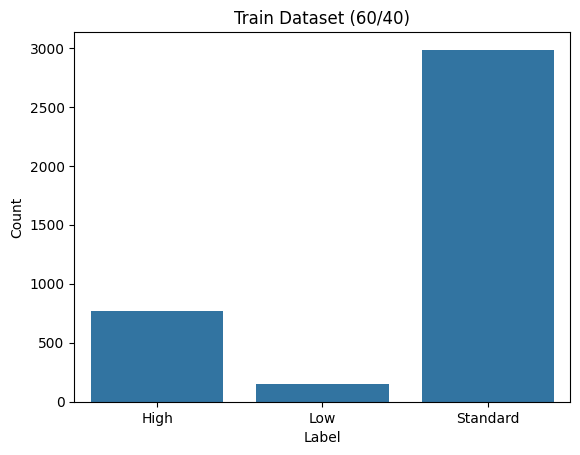

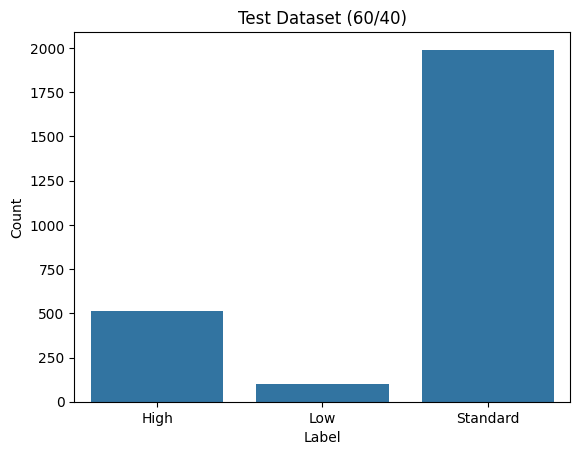

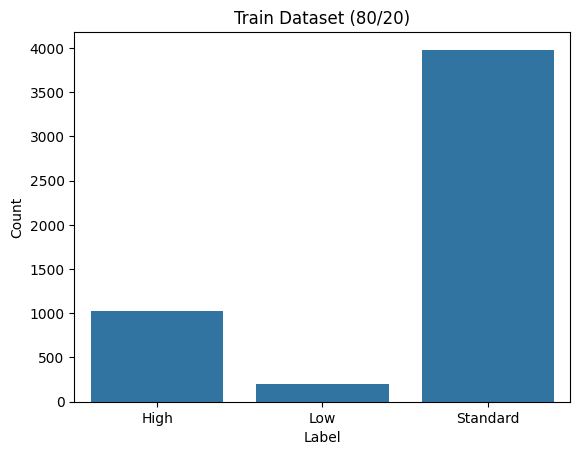

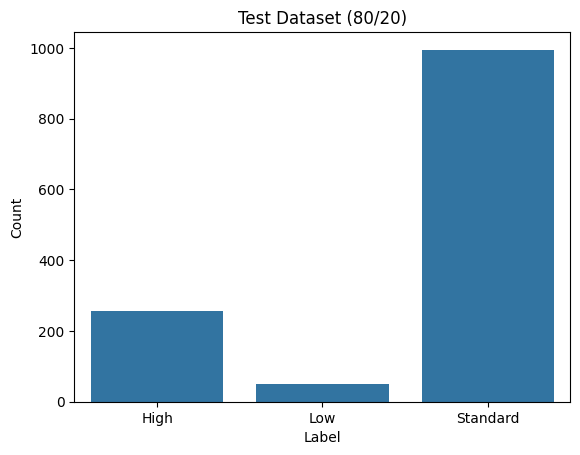

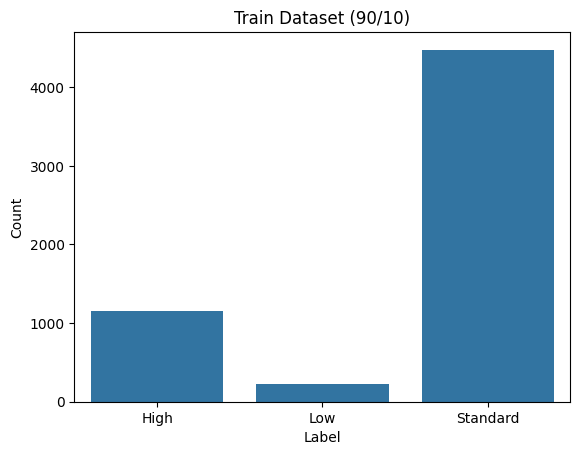

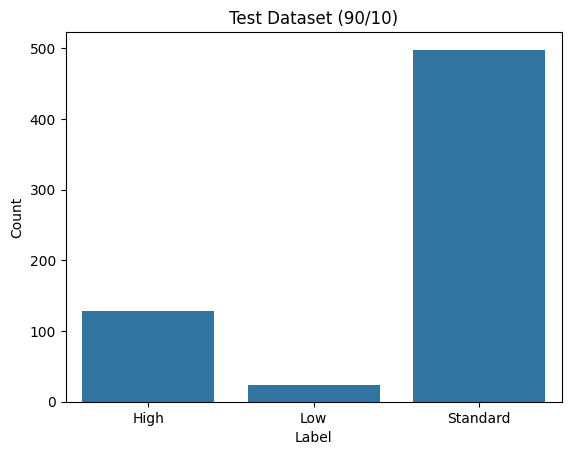

In [22]:
for split_name, dataset in datasets.items():
    plot_label_distribution(dataset['label_train'], f'Train Dataset ({split_name})')
    plot_label_distribution(dataset['label_test'], f'Test Dataset ({split_name})')

## 2.2 Xây dựng bộ phân loạii

In [23]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import graphviz

- Hàm huấn luyện và trực quan hóa cây quyết định

In [24]:
dir_path = CONFIG.RESULTS_BASE_TREE_DIR

def train_and_visualize(features_train, labels_train, features_test, labels_test, split_name):
    # Huấn luyện cây quyết định
    model = DecisionTreeClassifier(criterion='entropy', random_state=rand_value)
    model.fit(features_train, labels_train)
    
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    
    # Đánh giá hiệu suất mô hình
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)

    print(f"Results for split {split_name}")
    print("- Classification Report:")
    print(classification_report(labels_test_decoded, predictions_decoded))

    accuracy = accuracy_score(labels_test, predictions)
    print(f"Accuracy: {accuracy:.6f}\n")

    # Trực quan hóa cây quyết định
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=features_train.columns,
        class_names=['Low','Standard','High'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    filepath = f"{dir_path}/{split_name.replace('/', '_')}/graph"
    graph.render(filepath, format="pdf")
    # graph.view()  # Mở cây trực tiếp
    # display(graph)
    print(f"- Saved tree visualization for {split_name}")
    print("------------------------------------------\n")

- Huấn luyện và trực quan hóa với từng tập con

In [25]:
for split_name, dataset in datasets.items():
    train_and_visualize(
        features_train=dataset['feature_train'],
        labels_train=dataset['label_train'],
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        split_name=split_name
    )

Results for split 40/60
- Classification Report:
              precision    recall  f1-score   support

        High       0.52      0.54      0.53       766
         Low       0.19      0.20      0.20       148
    Standard       0.85      0.84      0.85      2985

    accuracy                           0.76      3899
   macro avg       0.52      0.53      0.52      3899
weighted avg       0.76      0.76      0.76      3899

Accuracy: 0.758143

- Saved tree visualization for 40/60
------------------------------------------

Results for split 60/40
- Classification Report:
              precision    recall  f1-score   support

        High       0.57      0.58      0.57       511
         Low       0.22      0.20      0.21        98
    Standard       0.86      0.86      0.86      1990

    accuracy                           0.78      2599
   macro avg       0.55      0.55      0.55      2599
weighted avg       0.78      0.78      0.78      2599

Accuracy: 0.778376

- Saved tree visual

## 2.3 Đánh giá các bộ phân loại

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

- Hàm đánh giá mô hình và tạo báo cáo

In [27]:
def evaluate_model(features_test, labels_test, model, split_name):
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    
     # Chuyển ngược về nhãn
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)

    # Classification Report
    print("------------------------------------------\n")
    print(f"- Classification Report for split {split_name}")
    print(classification_report(labels_test_decoded, predictions_decoded))
    # print(classification_report(labels_test, predictions))
    
    # Confusion Matrix
    cm = confusion_matrix(labels_test, predictions)
    print(f"- Confusion Matrix for split {split_name}:\n{cm}")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Confusion Matrix for {split_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Trả về mô hình và độ chính xác
    accuracy = accuracy_score(labels_test, predictions)
    return accuracy

- Lặp qua từng tập con để huấn luyện, đánh giá, và lưu kết quả

------------------------------------------

- Classification Report for split 40/60
              precision    recall  f1-score   support

        High       0.52      0.54      0.53       766
         Low       0.19      0.20      0.20       148
    Standard       0.85      0.84      0.85      2985

    accuracy                           0.76      3899
   macro avg       0.52      0.53      0.52      3899
weighted avg       0.76      0.76      0.76      3899

- Confusion Matrix for split 40/60:
[[ 416   14  336]
 [  13   29  106]
 [ 368  106 2511]]


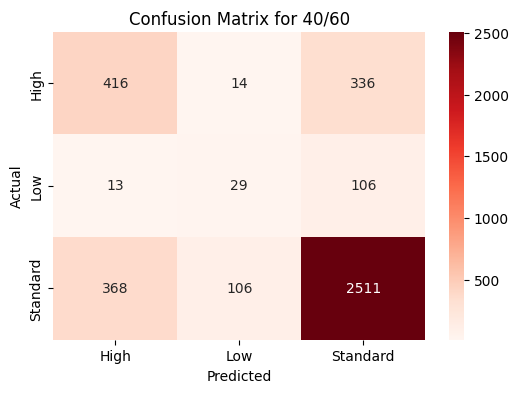

------------------------------------------

- Classification Report for split 60/40
              precision    recall  f1-score   support

        High       0.57      0.58      0.57       511
         Low       0.22      0.20      0.21        98
    Standard       0.86      0.86      0.86      1990

    accuracy                           0.78      2599
   macro avg       0.55      0.55      0.55      2599
weighted avg       0.78      0.78      0.78      2599

- Confusion Matrix for split 60/40:
[[ 296    7  208]
 [   5   20   73]
 [ 220   63 1707]]


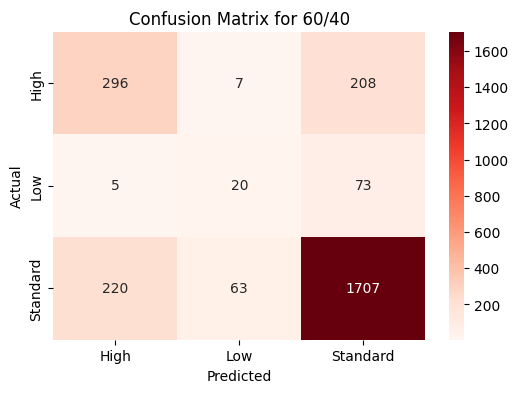

------------------------------------------

- Classification Report for split 80/20
              precision    recall  f1-score   support

        High       0.61      0.65      0.63       256
         Low       0.31      0.22      0.26        49
    Standard       0.88      0.87      0.88       995

    accuracy                           0.80      1300
   macro avg       0.60      0.58      0.59      1300
weighted avg       0.80      0.80      0.80      1300

- Confusion Matrix for split 80/20:
[[166   3  87]
 [  3  11  35]
 [104  22 869]]


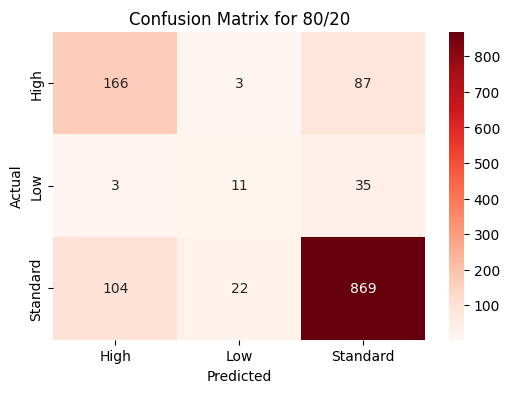

------------------------------------------

- Classification Report for split 90/10
              precision    recall  f1-score   support

        High       0.57      0.66      0.61       128
         Low       0.33      0.21      0.26        24
    Standard       0.88      0.86      0.87       498

    accuracy                           0.80       650
   macro avg       0.60      0.58      0.58       650
weighted avg       0.80      0.80      0.80       650

- Confusion Matrix for split 90/10:
[[ 84   2  42]
 [  3   5  16]
 [ 60   8 430]]


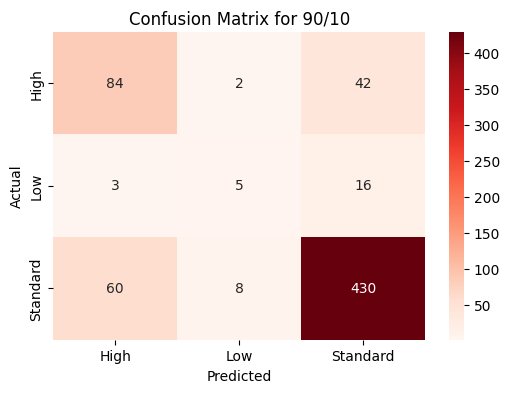

In [28]:
results = {}
for split_name, dataset in datasets.items():
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', random_state=rand_value)
    model.fit(dataset['feature_train'], dataset['label_train'])
    
    # Đánh giá mô hình
    accuracy = evaluate_model(
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        model=model,
        split_name=split_name
    )
    
    # Lưu kết quả
    results[split_name] = accuracy

- Hiển thị tổng hợp kết quả độ chính xác

In [29]:
for split_name, accuracy in results.items():
    print(f"Accuracy for {split_name}: {accuracy:.6f}")

Accuracy for 40/60: 0.758143
Accuracy for 60/40: 0.778376
Accuracy for 80/20: 0.804615
Accuracy for 90/10: 0.798462


## IV Độ sâu và độ chính xác

- Lấy bộ dữ liệu huấn luyện và kiểm tra 80/20

In [30]:
default_split = CONFIG.DEFAULT_SPLIT

X_train = datasets[default_split]['feature_train']
y_train = datasets[default_split]['label_train']
X_test  = datasets[default_split]['feature_test']
y_test  = datasets[default_split]['label_test']

- Thử nghiệm với các giá trị max_depth khác nhau

In [31]:
accuracy_scores = {}
max_depth_values = CONFIG.MAX_DEPTH_VALUES
dir_path = CONFIG.RESULTS_TREE_MAX_DEPTH_DIR

for max_depth in max_depth_values:
    # Tạo và huấn luyện cây quyết định với max_depth
    model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Dự đoán và tính độ chính xác
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[max_depth] = accuracy
    
    # Trực quan hóa cây quyết định
    print(f"Decision Tree with max_depth={max_depth}")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=encoder.classes_,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    path = f"{dir_path}/max_depth_{'None' if max_depth is None else max_depth}/graph"
    graph.render(path, format="pdf")
    print(f"- Saved tree visualization for {path}.pdf")
    print("------------------------------------------\n")


Decision Tree with max_depth=None
- Saved tree visualization for Results/Tree Max Depth/max_depth_None/graph.pdf
------------------------------------------

Decision Tree with max_depth=2
- Saved tree visualization for Results/Tree Max Depth/max_depth_2/graph.pdf
------------------------------------------

Decision Tree with max_depth=3
- Saved tree visualization for Results/Tree Max Depth/max_depth_3/graph.pdf
------------------------------------------

Decision Tree with max_depth=4
- Saved tree visualization for Results/Tree Max Depth/max_depth_4/graph.pdf
------------------------------------------

Decision Tree with max_depth=5
- Saved tree visualization for Results/Tree Max Depth/max_depth_5/graph.pdf
------------------------------------------

Decision Tree with max_depth=6
- Saved tree visualization for Results/Tree Max Depth/max_depth_6/graph.pdf
------------------------------------------

Decision Tree with max_depth=7
- Saved tree visualization for Results/Tree Max Depth/max

- Hiển thị bảng kết quả

In [32]:
print("max_depth\tAccuracy")
for max_depth, accuracy in accuracy_scores.items():
    print(f"{'None' if max_depth is None else max_depth}\t\t{accuracy:.6f}")

max_depth	Accuracy
None		0.804615
2		0.753846
3		0.766154
4		0.776154
5		0.778462
6		0.783077
7		0.786923


- Vẽ biểu đồ độ chính xác

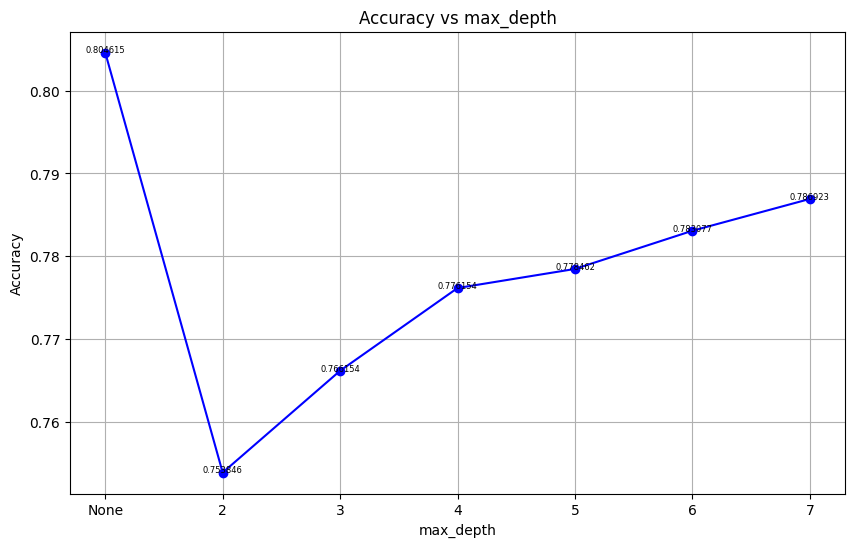

In [33]:
depth_labels = ['None' if d is None else d for d in max_depth_values]
accuracy_values = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.plot(depth_labels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
for i, txt in enumerate(accuracy_values):
    plt.text(i, accuracy_values[i], f"{accuracy_values[i]:.6f}", fontsize=6, ha='center')

plt.show()